In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error

In [64]:
# Load dataset
data = pd.read_csv('../assets/sg_dengue_w_weather_df.csv')
data.head(2)

,Year,eWeek,Cases,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),...,Max Wind Speed (km/h),Year_eWeek,Month,Year_Month,Search Interest,Date,Mean Wind Speed (km/h)_W-6,Weekly Rainfall Total (mm)_W-2,Mean Temperature (°C)_W-3,Search Interest_W-2
0,2014,1,437.0,12.967797,8.641818,10.209091,11.001818,26.932018,31.615,25.110,...,38.394737,2014-1,12,2014-12,48,2014-01-06,NaN,NaN,NaN,NaN
1,2014,2,479.0,57.510169,12.750909,15.549091,18.998182,26.333960,32.165,24.705,...,40.494737,2014-2,1,2014-1,60,2014-01-13,NaN,NaN,NaN,NaN


In [66]:
# only look at relevant columns
relevant_columns = ['Cases', 'eWeek', 'Month', 'Daily Rainfall Total (mm)', 'Search Interest_W-2','Mean Wind Speed (km/h)_W-6', 'Mean Temperature (°C)_W-3']
data = data[relevant_columns]
data.head(1)

,Cases,eWeek,Month,Daily Rainfall Total (mm),Search Interest_W-2,Mean Wind Speed (km/h)_W-6,Mean Temperature (°C)_W-3
0,437.0,1,12,12.967797,NaN,NaN,NaN


In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Cases                       260 non-null    float64
 1   eWeek                       260 non-null    int64  
 2   Month                       260 non-null    int64  
 3   Daily Rainfall Total (mm)   260 non-null    float64
 4   Search Interest_W-2         258 non-null    float64
 5   Mean Wind Speed (km/h)_W-6  254 non-null    float64
 6   Mean Temperature (°C)_W-3   257 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 14.3 KB


In [68]:
data['eWeek'] = data['eWeek'].astype('category')
data['Month'] = data['Month'].astype('category')

In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Cases                       260 non-null    float64 
 1   eWeek                       260 non-null    category
 2   Month                       260 non-null    category
 3   Daily Rainfall Total (mm)   260 non-null    float64 
 4   Search Interest_W-2         258 non-null    float64 
 5   Mean Wind Speed (km/h)_W-6  254 non-null    float64 
 6   Mean Temperature (°C)_W-3   257 non-null    float64 
dtypes: category(2), float64(5)
memory usage: 13.6 KB


In [70]:
data['Lag_2'] = data[['Cases']].shift(2)
data['Weekly Rainfall Total (mm)_W-6'] = data['Daily Rainfall Total (mm)'].shift(6)

In [71]:
# drop the original no-lag variables and month
these_columns = ['Month', 'Daily Rainfall Total (mm)']
data = data.drop(these_columns, axis=1)

In [72]:
data.head()

,Cases,eWeek,Search Interest_W-2,Mean Wind Speed (km/h)_W-6,Mean Temperature (°C)_W-3,Lag_2,Weekly Rainfall Total (mm)_W-6
0,437.0,1,NaN,NaN,NaN,NaN,NaN
1,479.0,2,NaN,NaN,NaN,NaN,NaN
2,401.0,3,48.0,NaN,NaN,437.0,NaN
3,336.0,4,60.0,NaN,26.932018,479.0,NaN
4,234.0,5,60.0,NaN,26.333960,401.0,NaN


In [73]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254 entries, 6 to 259
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Cases                           254 non-null    float64 
 1   eWeek                           254 non-null    category
 2   Search Interest_W-2             254 non-null    float64 
 3   Mean Wind Speed (km/h)_W-6      254 non-null    float64 
 4   Mean Temperature (°C)_W-3       254 non-null    float64 
 5   Lag_2                           254 non-null    float64 
 6   Weekly Rainfall Total (mm)_W-6  254 non-null    float64 
dtypes: category(1), float64(6)
memory usage: 16.6 KB


In [74]:
# Split the data into features and target variable
X = data.drop('Cases', axis=1)  # Features
y = data['Cases']                # Target variable

In [75]:
# Split the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) # 80% training, 20% testing

In [101]:
# Create a Random Forest Regressor
rf = RandomForestRegressor(n_estimators=500, max_depth=4, max_leaf_nodes=2, max_samples=10)  # Adjust hyperparameters as needed

# Train the model using the training sets
rf.fit(X_train, y_train)

# Predict the response for the test dataset
y_pred = rf.predict(X_test)

In [77]:
# Evaluate the model performance (calculate RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # To get RMSE
print("Root Mean Squared Error (RMSE) on testing set:", rmse)

Root Mean Squared Error (RMSE) on testing set: 70.30173990151266


In [78]:
# VS training data
y_pred2 = rf.predict(X_train)

rmse2 = mean_squared_error(y_train, y_pred2, squared=False)  # To get RMSE
print("Root Mean Squared Error (RMSE) on training set:", rmse2)

Root Mean Squared Error (RMSE) on training set: 101.49815211647342


In [79]:
# Perform k-fold cross-validation
cv_rmse = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Calculate average RMSE across folds (use negative MSE as returned by cv_rmse) 
mean_cv_rmse = np.mean(np.sqrt(-cv_rmse))  # Convert to RMSE
print("Average RMSE across folds:", mean_cv_rmse)

Average RMSE across folds: 111.1473310960271


In [97]:
X.columns.tolist()

['eWeek',
 'Search Interest_W-2',
 'Mean Wind Speed (km/h)_W-6',
 'Mean Temperature (°C)_W-3',
 'Lag_2',
 'Weekly Rainfall Total (mm)_W-6']

In [80]:
# Initialize RFECV
rfecv = RFECV(estimator=rf, step=0.05, cv=5, scoring='neg_mean_squared_error')

# Fit RFECV
rfecv.fit(X_train, y_train)

RFECV(cv=5,
      estimator=RandomForestRegressor(max_depth=3, max_leaf_nodes=2,
                                      max_samples=10, n_estimators=500),
      scoring='neg_mean_squared_error', step=0.05)

In [81]:
# Calculate the RMSE for each cross-validation fold
rmse_scores = np.sqrt(-rfecv.grid_scores_)
print("Average RMSE across folds:", {np.mean(rmse_scores)})

Average RMSE across folds: {107.85847078228679}


C:\Users\idea\Anaconda3\envs\dsi-sg\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


In [82]:
# Get the number of best features
print('Optimal number of features:', rfecv.n_features_)

Optimal number of features: 1


In [83]:
# best features 
selected_features = X.columns[rfecv.support_]
print(selected_features)

Index(['Lag_2'], dtype='object')


In [84]:
# feature ranking
feature_ranking = rfecv.ranking_
print(feature_ranking)

[4 2 3 5 1 6]


In [85]:
X.columns

Index(['eWeek', 'Search Interest_W-2', 'Mean Wind Speed (km/h)_W-6',
       'Mean Temperature (°C)_W-3', 'Lag_2', 'Weekly Rainfall Total (mm)_W-6'],
      dtype='object')

In [86]:
x_axis = y_test.index

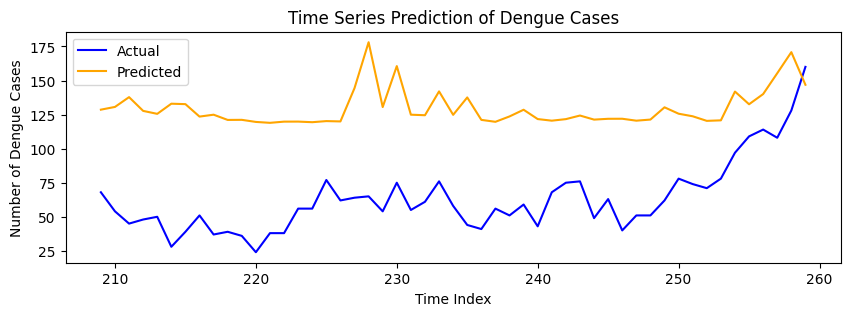

In [87]:
plt.figure(figsize=(10, 3))
plt.plot(x_axis, y_test, label='Actual', color='blue')
plt.plot(x_axis, y_pred, label='Predicted', color='orange')
plt.xlabel('Time Index')
plt.ylabel('Number of Dengue Cases')
plt.title('Time Series Prediction of Dengue Cases')
plt.legend()
plt.show()